## 1. GPU 설치하기(만약에 CPU로 사요하면 이 단계를 건너뛰기)



In [ ]:
import tensorflow as tf     # 텐서플로가 임포트됨, tensorflow: 구글이 2015년 11월 오픈소스로 공개한 딥러닝 라이브러리
gpus = tf.config.list_physical_devices("GPU")      # GPU환경을 설치하기

if gpus:
    gpu0 = gpus[0]     
    tf.config.set_visible_devices([gpu0],"GPU")       # 만약에 여러개 GPU가 있으면 0번째 것만 사용


## 2. 데이터 입력하기 

In [ ]:
import matplotlib.pyplot as plt      # matplotlib.pyplot이 임포트됨
                       # 파이썬에서 matplotlib 패커지에는 pyplot 이라는 라이브러리가 있는데 실제 그래프는 pyplot을 사용하여 작성하게 됨
import os,PIL      # os: 내 컴퓨터의 디렉토리(폴더)나 경로, 파일 등을 활용하게 도와주는 모듈
             # PIL: 파이썬 이미지 처리 pillow(PIL)가 임포트됨

import numpy as np      # 넘파이가 임포트됨 
np.random.seed(1)        # np.ramdom.seed(n) 함수: 난수를 만듦

import tensorflow as tf      # 텐서플로가 임포트됨
tf.random.set_seed(1)

from tensorflow import keras      # 케라스가 임포트됨
from tensorflow.keras import layers,models      # 층 및 모델이 임포트됨

import pathlib      # pathlib: 객체 지향 파일 시스템 경로 

In [ ]:
data_dir = "/content/drive/MyDrive/weather_photos"      # 데이터 주소를 입력하기
data_dir = pathlib.Path(data_dir)

## 3. 데이터 확인하기

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))      # len()함수를 통해 총 사진 수량을 확인하기 
print("총 사진 수량：",image_count)

총 사진 수량： 1125


In [ ]:
roses = list(data_dir.glob('sunrise/*.jpg'))      # 첫 번쨰 사진을 확인
PIL.Image.open(str(roses[0]))

Output hidden; open in https://colab.research.google.com to view.



## 4. 데이터 전처리 

In [ ]:
# 사진 사이즈를 설정 
batch_size = 64
img_height = 180
img_width = 180

In [ ]:
# 훈련 세트
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1125 files belonging to 4 classes.
Using 900 files for training.


In [ ]:
# 검증 세트
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1125 files belonging to 4 classes.
Using 225 files for validation.


In [ ]:
# class_names을 통해 출력 데이터 세트의 레이블을 확인 
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'sunrise']


In [ ]:
# train_ds의 데이터 유형을 확인 
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## 5. 데이터 시각화

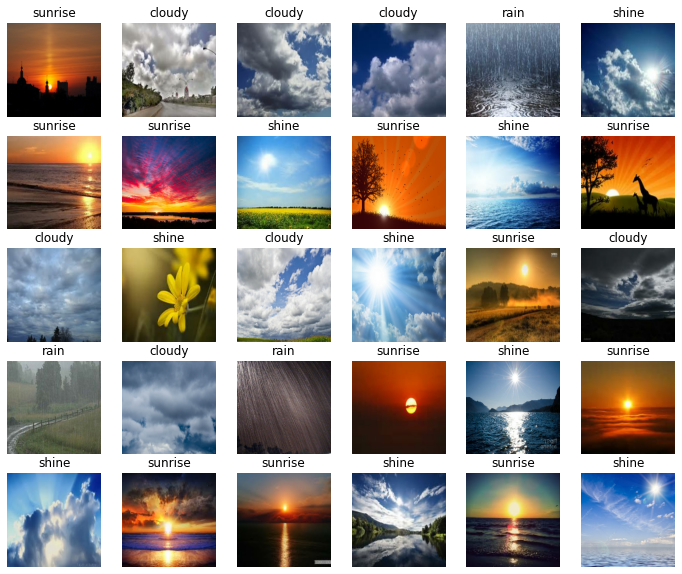

In [ ]:
# 사진이 매번 다르게 나옴 

plt.figure(figsize=(12, 10))      # 사진 사이즈를 설정하기

for images, labels in train_ds.take(1):
    for i in range(30):      # 총 사진 수량 30장을 지정하기 
        ax = plt.subplot(5, 6, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])     # 사진 제목이 확정하기  
        plt.savefig('pic1.jpg', dpi=600)     # savefig(): 사진 저장하기    
                             # dpi: 매개변수로 해상도 지정하기
        plt.axis("off")


In [ ]:
# 사진 모양 보기
for image_batch, labels_batch in train_ds:      
    print(image_batch.shape)      # 사진 크기 확인하기
    print(labels_batch.shape)     # 레이블 크기 확인하기
    break


(64, 180, 180, 3)
(64,)


In [ ]:
# 훈련 세트와 검증 세트를 tf.data.AUTOTUNE으로 설정하면 tf.data 런타임이 실행 시에 동적으로 값을 조정하도록 만들기 
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## 6. 합성곱 신경망 만들기

In [ ]:
num_classes = 4      # 총 클래스 수

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),   
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 풀링층1，커널3*3  
    layers.AveragePooling2D((2, 2)),               # 풀링층1，2*2sampling
    layers.Conv2D(32, (3, 3), activation='relu'),  # 합성곱층2，커널3*3
    layers.AveragePooling2D((2, 2)),               # 풀링층2，2*2sampling
    layers.Conv2D(64, (3, 3), activation='relu'),  #  합성곱층3，커널3*3
    layers.Dropout(0.3),                    # 드롭아웃을 넣어 과대적합을 막아 성능을 조금 더 개선하기
    
    layers.Flatten(),                       # flatten 클래스 다음에 Dense 은닉층, 마지막으로 Dense 출력층의 순서대로 구성
    layers.Dense(128, activation='relu'),   # 은닉층, 추가 특정을 추출하기
    layers.Dense(num_classes)               # 출력층, 예측 결과를 출력하기 
])

model.summary()      # summary()메서드로 모델 구조를 출력


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 89, 89, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 43, 43, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

## 7. 모델 컴파일과 훈련
- 옵티마이저: 케라스에서 제공하는 다양한 종류의 경사 하강법 알고리즘

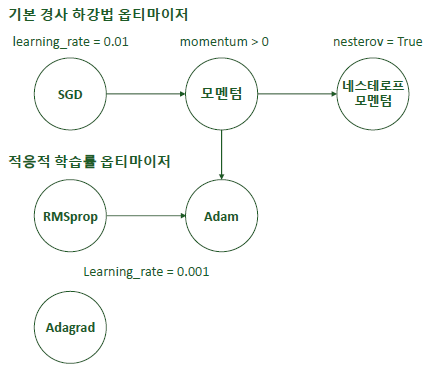
- loss함수: 손실 함수는 어떤 문제에서 머신러닝 알고리즘이 얼마나 엉터리인지를 측정하는 기준
- complie(): 모델 객체를 만든 후 훈련하기 전에 사용할 손실 함수와 측정 지표 등을 지정하는 메서드 

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)      

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs = 50      # epochs: 반복할 에포크 횟수를 epochs 매개변수로 지정하기
            # fit() 모델을 훈련하는 메서드 
history = model.fit(      
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50
15/15 [==============================] - 84s 3s/step - loss: 1.3733 - accuracy: 0.5178 - val_loss: 0.6832 - val_accuracy: 0.6578
Epoch 2/50
15/15 [==============================] - 24s 2s/step - loss: 0.6114 - accuracy: 0.7833 - val_loss: 0.4857 - val_accuracy: 0.7911
Epoch 3/50
15/15 [==============================] - 24s 2s/step - loss: 0.3873 - accuracy: 0.8567 - val_loss: 0.4635 - val_accuracy: 0.7956
Epoch 4/50
15/15 [==============================] - 24s 2s/step - loss: 0.3168 - accuracy: 0.8789 - val_loss: 0.4150 - val_accuracy: 0.8356
Epoch 5/50
15/15 [==============================] - 24s 2s/step - loss: 0.2519 - accuracy: 0.9022 - val_loss: 0.8039 - val_accuracy: 0.7111
Epoch 6/50
15/15 [==============================] - 26s 2s/step - loss: 0.3280 - accuracy: 0.8700 - val_loss: 0.4859 - val_accuracy: 0.8089
Epoch 7/50
15/15 [==============================] - 24s 2s/step - loss: 0.2027 - accuracy: 0.9189 - val_loss: 0.4268 - val_accuracy: 0.8489
Epoch 8/50
15/15 [==

In [ ]:
model.save('model')      # 모델 저장하기 

## 8. 모델 평가

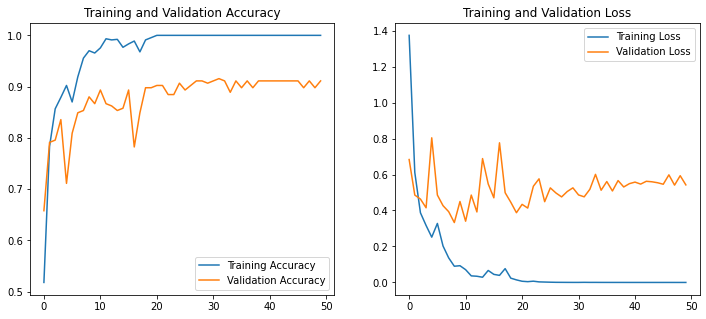

In [ ]:
model = tf.keras.models.load_model('model')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('pic2.jpg', dpi=600)      # dpi: 매개변수로 해상도 지정하기
plt.show()
